# Supplementary Figure 5. SRSF3 is a global regulatory factor
A. Cleavage pattern changes   
C. Composition of clusters  
D. Cluster V  
E. Classification changes in detail  
F. CNNC and SRSF3-mediated change  
G. Secondary structure of SRSF3-rescued miRNAs

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-10-13.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201013/


In [4]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec
from collections import defaultdict, Counter
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

#### Import supplementary tables

In [6]:
s1 = pd.read_csv('supplementary/201012_s1_pri-info.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201012_s2_pri-construct.csv', header=1, index_col=0)
s5 = pd.read_csv('supplementary/201012_s5_pri-structure.csv', header=1, index_col=0)
s6 = pd.read_csv('supplementary/201012_s6_cleavage-patterns.csv', header=1, index_col=0)
s7 = pd.read_csv('supplementary/201012_s7_cleavage-sites.csv', header=1, index_col=0)
s8 = pd.read_csv('supplementary/201012_s8_cleavage-patterns-srsf3.csv', header=1, index_col=0)
print 's1:\t%s'%', '.join(list(s1.columns))
print 's2:\t%s'%', '.join(list(s2.columns)[:6])
print 's5:\t%s'%', '.join(list(s5.columns)[-10:])
print 's6:\t%s'%', '.join(list(s6.columns)[-4:])
print 's7:\t%s'%', '.join(list(s7.columns))
print 's8:\t%s'%', '.join(list(s8.columns))

s1:	5p mature, 5p sequence, 3p mature, 3p sequence, Note
s2:	Chr, Start, End, Strand, Construct sequence, 100way phyloP scores (pre-miRNA -/+ 100nt)
s5:	117, 118, 119, 120, 121, 122, 123, 124, 125, symbolized structure
s6:	Relative position from miRBase site, Cleavage Specificity, Cleavage Imbalance, Cleavage type
s7:	Chr, miRBase 5' site, miRBase 3' site, IVP 5' site, IVP 3' site, fCLIP 5' site, fCLIP 3' site, Strand, Type, IVP PCS, fCLIP PCS
s8:	Chr, 5' cleavage site, 3' cleavage site, Strand, Cleavage type, CP_wo_SRSF3, CP_w_SRSF3, CS_wo_SRSF3, CS_w_SRSF3, Productive_wo_SRSF3, Productive_w_SRSF3, Alternative_wo_SRSF3, Alternative_w_SRSF3, Nick_wo_SRSF3, Nick_w_SRSF3, Inverted_wo_SRSF3, Inverted_w_SRSF3


In [7]:
def get_pre_position(pri):
    constructseq = s2.loc[pri, 'Construct sequence'].replace('T','U')
    seq5p = s1.loc[pri, '5p sequence']
    seq3p = s1.loc[pri, '3p sequence']
    if seq5p=='n.a.' or constructseq.find(seq5p)==-1:
        prestart = 0
    else:
        prestart = constructseq.find(seq5p)+1
    if seq3p=='n.a.' or constructseq.find(seq3p)==-1:
        preend = 125
    else:
        preend = constructseq.rfind(seq3p)+len(seq3p)
    return prestart, preend

In [8]:
allpris = s1.index
preposition = { pri:get_pre_position(pri) for pri in allpris }
print len(preposition)

1881


In [9]:
mirtrons = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Mirtron')>=0 ]
capped = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Capped miRNA')>=0 ]
drosensitive = [ pri for pri in allpris if s1.loc[pri,'Note'].find('DROSHA KO-sensitive')>=0 ]
fclipdetected = [ pri for pri in allpris if s1.loc[pri,'Note'].find('fCLIP site-determined')>=0 ]
dbmirs = [ pri for pri in allpris if s1.loc[pri,'Note'].find('MirGeneDB')>=0 ]
print len(mirtrons), len(capped), len(drosensitive), len(fclipdetected), len(dbmirs)

239 11 157 281 519


In [10]:
constseqs = dict(s2['Construct sequence'])
print len(constseqs)

1881


In [11]:
singlemp = set(s6[s6['Cleavage type']=='single'].index)
multimp = set(s6[s6['Cleavage type']=='multiple'].index)
invertedmp = set(s6[s6['Cleavage type']=='inverted'].index)
nick5mp = set(s6[s6['Cleavage type']=='nick5'].index)
nick3mp = set(s6[s6['Cleavage type']=='nick3'].index)
nickmp = list(nick5mp) + list(nick3mp)
nonspecmp = set(s6[s6['Cleavage type']=='non-specific'].index)
dcsmirsmp = list(singlemp) + list(multimp)
nodcsmp = list(invertedmp) + list(nickmp) + list(nonspecmp)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirsmp), len(nodcsmp))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(singlemp), len(multimp), len(invertedmp), len(nickmp), len(nonspecmp))
print "5' nick: %s, 3' nick: %s" % (len(nick5mp), len(nick3mp))

Productive: 512, Unproductive: 1304
Single: 445, Multiple: 67, Inverted: 156, Nick: 107, Non-specific: 1041
5' nick: 72, 3' nick: 35


# A. Cleavage pattern changes

In [12]:
attributes = ['Productive','Alternative','Nick','Inverted']

In [13]:
summtbl = s8.reindex(s8['Productive_wo_SRSF3'].dropna().index)
difftbl = pd.DataFrame()
for attri in attributes:
    if attri=='Nick':
        difftbl[attri] = np.log2((abs(summtbl['%s_w_SRSF3'%attri])+1)/\
                                 (abs(summtbl['%s_wo_SRSF3'%attri])+1))
    else:
        difftbl[attri] = np.log2((summtbl['%s_w_SRSF3'%attri]+1)/\
                                 (summtbl['%s_wo_SRSF3'%attri]+1))
difftbl.head()

,Productive,Alternative,Nick,Inverted
Pri-miRNA,,,,
hsa-let-7a-1,5.141934,-0.025331,0.041494,0.000691
hsa-let-7a-2,4.916338,0.037195,-0.159983,0.034052
hsa-let-7a-3,4.404454,0.004157,0.011206,-0.023819
hsa-let-7b,5.734622,-0.014259,-0.006870,-0.016782
hsa-let-7c,7.646225,0.029231,0.040335,-0.605388


In [14]:
bind = defaultdict(lambda: np.arange(-.62,.63,.04))
bind['Productive'] = np.arange(-.75,8.86,.3)
xsl, ysl = [], []
for attri in attributes:
    vs,ts = np.histogram(difftbl[attri], bins=bind[attri])
    xsl.append((ts[1:]+ts[:-1])/2)
    ysl.append(vs/vs.sum())
labels = attributes

In [15]:
def draw_sig(ax,xs,ys):
    for x in xs:
        ax.plot([x,x],[0,max(ys)*.15],color='k',lw=2)
        ax.scatter([x],[max(ys)*.15],s=20,color='k',zorder=2)

Text(-0.1,0.5,u'Fraction')

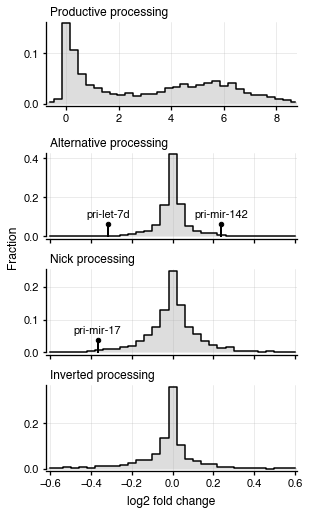

In [16]:
fig = plt.figure(figsize=(3.8,6.5))
gs1 = gridspec.GridSpec(1,1); gs1.update(left=.04, right=.96, top=.98, bottom=.8)
ax1 = fig.add_subplot(gs1[0])
gs2 = gridspec.GridSpec(3,1); gs2.update(left=.04, right=.96, top=.7, bottom=.02,hspace=.35)
ax2 = fig.add_subplot(gs2[0]); ax3 = fig.add_subplot(gs2[1]); ax4 = fig.add_subplot(gs2[2])
axes = [ax1,ax2,ax3,ax4]
for ax,xs,ys,label in zip(axes,xsl,ysl,labels):
    ymax = max(ys)
    xmin, xmax = min(xs), max(xs)
    xlen = xmax-xmin
    ax.text(min(xs),ymax*1.1,'%s processing'%label,fontsize=12)
    ax.grid(ls='-',lw=.5,zorder=-1)
    ax.spines['left'].set_bounds(0,ymax*1.02)
    ax.set_xlim(xmin-.02*xlen,xmax+.01*xlen)
    ax.set_ylim(ymax*-.03, ymax*1.02)
    ax.step(xs,ys,color='black',where='mid',zorder=2)
    ax.bar(xs,ys,color='#ababab',width=xs[1]-xs[0],alpha=.4,lw=0,zorder=2)
    
for ax in [ax2,ax3]:
    ax.set_xticklabels([])

let7d_alt = difftbl.loc['hsa-let-7d','Alternative']
mir142_alt = difftbl.loc['hsa-mir-142','Alternative']
mir17_nick = difftbl.loc['hsa-mir-17','Nick']
draw_sig(ax2,[let7d_alt, mir142_alt],ysl[1])
draw_sig(ax3,[mir17_nick],ysl[2])
axes[1].text(let7d_alt,.1,'pri-let-7d',ha='center',fontsize=11)
axes[1].text(mir142_alt,.1,'pri-mir-142',ha='center',fontsize=11)
axes[2].text(mir17_nick,.06,'pri-mir-17',ha='center',fontsize=11)
fig.text(.5,-.05,'log2 fold change', fontsize=12,ha='center')
fig.text(-.1,.5,'Fraction',fontsize=12,va='center',rotation=90)
#fig.savefig(resultpath + '200917_s5a__cleavage_pattern_change.pdf')#,dpi=300)

# C. Composition of clusters

In [17]:
from sklearn.cluster import AgglomerativeClustering

In [18]:
cpcut = 3
diffcls = difftbl[difftbl['Productive']>cpcut].iloc[:,1:]
diffcls['Alternative'] = diffcls['Alternative']*2
print len(diffcls)
diffcls.head(1)

753


,Alternative,Nick,Inverted
Pri-miRNA,,,
hsa-let-7a-1,-0.050661,0.041494,0.000691


In [19]:
x = np.array(diffcls)
ncls = 11
result = AgglomerativeClustering(n_clusters=ncls,affinity='euclidean',linkage='ward').fit(x)

In [20]:
clstd = dict(zip(diffcls.index, result.labels_))
mls = { i:[m for m,c in clstd.items() if c==i] for i in range(ncls) }
clsinp = difftbl.reindex(mls[0]).iloc[:,1:]
for i in range(1,ncls):
    clsinp = clsinp.append(difftbl.reindex(mls[i]).iloc[:,1:])

In [21]:
subml1 = [ m for m in clstd if clstd[m]==1 ]
subcluster = AgglomerativeClustering(n_clusters=2).fit(diffcls.reindex(subml1))
subml1 = sorted(subml1, key=lambda x:-subcluster.labels_[subml1.index(x)])

cls1 = [ m for m in clstd if clstd[m]==2 ]
cls2 = [ m for m in clstd if clstd[m]==5 ]
cls3 = [ m for m in clstd if clstd[m]==8 ]+[ m for m in clstd if clstd[m]==0 ]
cls4 = subml1+[ m for m in clstd if clstd[m]==6 ]
cls5 = [ m for m in clstd if clstd[m]==3 ]
cls6 = [ m for m in clstd if clstd[m]==9 ]+[ m for m in clstd if clstd[m]==4 ]+\
       [ m for m in clstd if clstd[m]==10 ]+[ m for m in clstd if clstd[m]==7 ]

In [22]:
clsl = [cls1,cls2,cls3,cls4,cls5,cls6]
clsinp = difftbl.reindex(clsl[0]).iloc[:,1:]
for ml in clsl[1:]:
    clsinp = clsinp.append(difftbl.reindex(ml).iloc[:,1:])

In [23]:
ctypes = ['Single','Alternative','Nick','Inverted','No']
colors = '#1b9e77 #7570b3 #e7298a #d95f02 #ababab'.split()
cls = [singlemp,multimp,nickmp,invertedmp,nonspecmp]
xsl = [ [ len([m for m in ml if m in cl])/len(ml) for ml in clsl ] for cl in cls ]
ys = range(len(clsl))

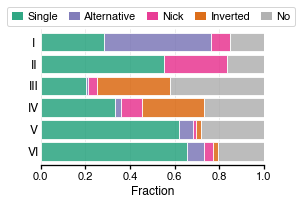

In [24]:
fig, ax = plt.subplots(1,1,figsize=(4,2.5))
left = np.array([0.]*len(clsl))
for xs,c,label in zip(xsl,colors,ctypes):
    ax.barh(ys,xs,left=left,color=c,lw=1,edgecolor='w',alpha=.8,height=.85,zorder=2)
    ax.barh([-1],[-1],color=c,alpha=.9,label=label)
    left+=np.array(xs)
ax.set_yticks(ys)
ax.set_yticklabels(['I','II','III','IV','V','VI','VII'], fontsize=12, ha='center')
ax.set_xlabel('Fraction', fontsize=12)
ax.set_xlim(0,1)
ax.set_ylim(-.6,5.6)
ax.tick_params(left='off')
ax.xaxis.grid(ls='-',lw=.5)
ax.invert_yaxis()
ax.spines['left'].set_visible(False)
ax.legend(loc=(-.15,1.02), ncol=5, handlelength=1, prop={'size':11}, 
          handletextpad=.4, columnspacing=1)
#fig.savefig(resultpath + '200917_s5b_cluster_composition.pdf')#,dpi=300)

# D. Cluster V

In [25]:
mp = [ s8.loc[m,'Nick_wo_SRSF3'] for m in cls5 ]
srsf3 = [ s8.loc[m,'Nick_w_SRSF3'] for m in cls5 ]
bins = np.arange(-1.02,1.03,.04)
ysl = [np.histogram(vs,bins=bins)[0].cumsum()/np.histogram(vs,bins=bins)[0].sum() 
       for vs in [mp,srsf3]]
xs = np.arange(-1,1.01,.02)

Text(0.5,-0.45,u'Cluster V\n(n = 82)')

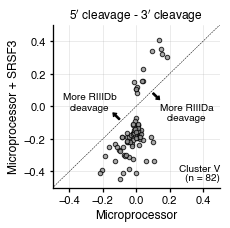

In [26]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(mp, srsf3,s=20,edgecolor='k',facecolor='#969696', alpha=.8, lw=1, zorder=2)
ax.set_title('5$^\prime$ cleavage - 3$^\prime$ cleavage', fontsize=12)
ax.set_xlabel('Microprocessor', fontsize=12)
ax.set_ylabel('Microprocessor + SRSF3', fontsize=12)
ax.set_xlim(-.5,.5)
ax.set_ylim(-.5,.5)
ax.plot([-1,1],[-1,1],'k--',lw=.5)
ax.grid(ls='-',lw=.5)

ax.arrow(-.1,-.08,-.04,.04,width=.01,length_includes_head=True,head_length=.02,head_width=.03,
        color='black')
ax.arrow(.1,.08,.04,-.04,width=.01,length_includes_head=True,head_length=.02,head_width=.03,
        color='black')
ax.text(-.28,-.02,'More RIIIDb\ncleavage',ha='center')
ax.text(.3,.02,'More RIIIDa\ncleavage',ha='center',va='top')
ax.text(.5,-.45,'Cluster V\n(n = %s)'%len(cls5),ha='right',linespacing=.9)
#fig.savefig(resultpath + '200918_s5c_clusterV.png',dpi=300)

# E. Classification changes in detail

In [27]:
single = set(s8[s8['Cleavage type']=='single'].index)
multi = set(s8[s8['Cleavage type']=='multiple'].index)
inverted = set(s8[s8['Cleavage type']=='inverted'].index)
nick5 = set(s8[s8['Cleavage type']=='nick5'].index)
nick3 = set(s8[s8['Cleavage type']=='nick3'].index)
nick = list(nick5) + list(nick3)
nonspec = set(s8[s8['Cleavage type']=='non-specific'].index)
dcsmirs = list(single) + list(multi)
nodcs = list(inverted) + list(nick) + list(nonspec)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirs), len(nodcs))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(single), len(multi), len(inverted), len(nick), len(nonspec))
print "5' nick: %s, 3' nick: %s" % (len(nick5), len(nick3))

Productive: 681, Unproductive: 1064
Single: 589, Multiple: 92, Inverted: 102, Nick: 52, Non-specific: 910
5' nick: 26, 3' nick: 26


In [28]:
stos = set(singlemp)&set(single)
stoa = set(singlemp)&set(multi)
atos = set(multimp)&set(single)
atoa = set(multimp)&set(multi)

itop = set(invertedmp)&set(dcsmirs)
ntop = set(nickmp)&set(dcsmirs)
notop = set(nonspecmp)&set(dcsmirs)

nton = set(nickmp)&set(nick)
itoi = set(invertedmp)&set(inverted)
notono = set(nonspecmp)&set(nonspec)
nptonp = itoi|nton|notono
nptonp = (set(nodcsmp)&set(nodcs))-nptonp

stonp = set(singlemp)&set(nodcs)
atonp = set(multimp)&set(nodcs)
ptonp = set(dcsmirsmp)&set(nodcs)

ptops = [stos,atoa,stoa,atos]
nptops = [itop,ntop,notop]
nptonps = [nton,itoi,notono,nptonp]
ptonps = [ptonp]# [stonp,atonp]
print map(len,ptops+nptops+nptonps+ptonps), sum(map(len,ptops+nptops+nptonps+ptonps))

[381, 32, 24, 33, 37, 37, 137, 14, 66, 798, 152, 34] 1745


In [29]:
xs = map(len,ptops+nptops+nptonps)#+ptonps)
ys = [0,1,2,3,4.5,5.5,6.5,8,9,10,11]#,12.5]
mplabel = ['single','alternative','single','alternative','inverted','nick','no',
           'nick','inverted','no','non-productive','productive']
srlabel = ['single','alternative','alternative','single','productive','productive','productive',
           'nick','inverted','no','non-productive','non-productive']
labels = ['single','alternative','nick','inverted','no']

In [30]:
labeld = {l:[l] for l in labels}
labeld['productive'] = ['single','alternative']
labeld['non-productive'] = ['inverted','nick','no']
colors = ['#e6550d','#424242','#732a06']
ctlabels = ['with Microprocessor only','with Microprocessor+SRSF3','unchanged']

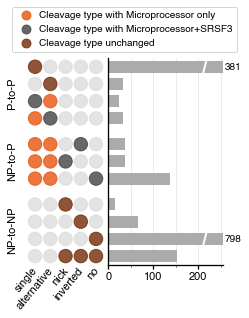

In [31]:
fig = plt.figure(figsize=(3.5,3.8))
gs = gridspec.GridSpec(1, 2, width_ratios=(2,3))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
for label, i in zip(labels,range(5)):
    cs = []
    for j in range(len(ys)):
        if label in labeld[mplabel[j]] and label in labeld[srlabel[j]]: cs.append('#732a06')
        elif label in labeld[mplabel[j]]: cs.append('#424242')
        elif label in labeld[srlabel[j]]: cs.append('#e6550d')
        else: cs.append('#dcdcdc')
    ax1.scatter([i]*len(ys),ys,s=180,color=cs,alpha=.8,lw=1,zorder=2)
for ctlabel, color in zip(ctlabels,colors):
    ax1.scatter([-5],[-5],s=80,color=color,alpha=.8,label='Cleavage type %s'%ctlabel)
ax1.legend(loc=(-.2,1.03),handletextpad=.3)

ax1.set_xlim(-.5,4.5); ax1.set_xticks([])
ax1.set_ylim(-.5,11.5); ax1.set_yticks([])
ax1.spines['left'].set_visible(False); ax1.spines['bottom'].set_visible(False)
ax1.invert_yaxis()
ax1.text(-1.5,1.5,'P-to-P',va='center',ha='center',rotation=90,fontsize=11)
ax1.text(-1.5,5.5,'NP-to-P',va='center',ha='center',rotation=90,fontsize=11)
ax1.text(-1.5,9.5,'NP-to-NP',va='center',ha='center',rotation=90,fontsize=11)

for i,label in zip(range(5),labels):
    ax1.text(i+.3,12,label,rotation=50,ha='right',fontsize=11)
    
ax2.barh(ys,xs,color='#ababab',height=.7, lw=0, edgecolor='k', zorder=2)
ax2.plot([210,220],[.5,-.5],lw=2,color='w',zorder=3)
ax2.plot([210,220],[10.5,9.5],lw=2,color='w',zorder=3)
ax2.text(260,0,'381',va='center')
ax2.text(260,10,'798',va='center')
ax2.set_xticks([50,150,250],minor=True)
ax2.set_yticks([])
ax2.set_xlim(0,255)
ax2.set_ylim(-.5,11.5)
ax2.invert_yaxis()
ax2.xaxis.grid(ls='-',lw=.5,which='both')

fig.subplots_adjust(wspace=.05)
#fig.savefig(resultpath+'200923_s5d_cleavage_type_change.pdf')#,dpi=300)

In [32]:
ctypetbl = pd.DataFrame()
for l1, ml1 in zip(labels,[singlemp,multimp,nickmp,invertedmp,nonspecmp]):
    for l2, ml2 in zip(labels,[single,multi,nick,inverted,nonspec]):
        ctypetbl.loc[l1,l2] = len(set(ml1)&set(ml2))
ctypetbl.astype(int)#.to_csv(resultpath + '200924_cleavage_type_change.csv')

,single,alternative,nick,inverted,no
single,381,24,7,1,24
alternative,33,32,1,0,1
nick,31,6,14,4,49
inverted,33,4,6,66,38
no,111,26,24,31,798


# F. CNNC and SRSF3-mediated change

In [33]:
def clv_to_relative_pos(mir, c5, c3):
    ps, pe, strand = s2.loc[mir, ['Start','End','Strand']]
    if strand=='+':
        return c5-ps+1, c3-ps+1
    return pe-c5+1, pe-c3+1

In [37]:
def has_cnnc(mir):
    pres, pree = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    rels, rele = clv_to_relative_pos(mir, int(pres), int(pree))
    f3seq = constseqs[mir][rele:]
    return bool(re.search('C[A-Z][A-Z]C', f3seq[15:min(len(f3seq),21)]))

In [35]:
nptop = itop|ntop|notop
print len(nptop)

211


In [38]:
ntpcnnc = [ m for m in nptop if has_cnnc(m) ]
ntpnocn = [ m for m in nptop if m not in ntpcnnc ]
data = [ len(ntpcnnc), len(ntpnocn) ]
frac = [ data[0]/len(nptop)*100, data[1]/len(nptop)*100 ]
colors = [ '#1b9e77', '#757575']
labels = ['w/ CNNC', 'w/o CNNC']
title = '211 miRNAs that become productive by SRSF3'
print data

[116, 95]


Text(-1.1,1.2,u'211 miRNAs that become productive by SRSF3')

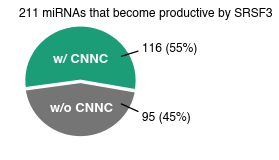

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))

ps, ts = ax.pie(data, colors=colors, explode=[.02]*2, startangle=-10, textprops={'fontsize':12})
for p in ps:
    p.set_linewidth(1.3)
    p.set_edgecolor('white')

ax.text(0,.35,'w/ CNNC',fontsize=13,weight='bold',ha='center',color='w')
ax.text(.02,-.55,'w/o CNNC',fontsize=13,weight='bold',ha='center',color='w')
ax.annotate('\n%s (%.0f%%)'%(data[0],frac[0]), xy=(.7,.45), xytext=(1.1,.5), fontsize=12,
           arrowprops={'arrowstyle':'-','lw':1.3},va='bottom')
ax.annotate('%s (%.0f%%)\n'%(data[1],frac[1]), xy=(.7,-.4), xytext=(1.1,-.55), fontsize=12,
           arrowprops={'arrowstyle':'-','lw':1.3},va='top')
ax.text(-1.1,1.2,title,fontsize=12)
#fig.savefig(resultpath + '200923_s5f_nptop_cnnc_v2.png',dpi=300)

# S5G. Secondary structure of SRSF3-rescued miRNAs

In [40]:
def get_str_info(mir):
    ctinfo = [ (int(i),pair) for i,pair in s5.iloc[:,:125].loc[mir].items() ]
    return ctinfo

In [41]:
def adjust_ct(strinfo, ajs, aje):
    newinfo = [ 1 if i<=ajs<pair or 0<pair<=ajs<i else 0 for i,pair in strinfo ] 
    return zip(range(1,126), newinfo)

In [42]:
ptop = set(dcsmirsmp)&set(dcsmirs)
nptop = set(nodcsmp)&set(dcsmirs)
nptonp = set(nodcsmp)&set(nodcs)
print len(ptop), len(nptop), len(nptonp)

470 211 1030


In [43]:
minss = 1
optiaj = 22
apicaljcs = {}
for mir in ptop|nptop:
    ps, pe = preposition[mir]
    constseq = constseqs[mir]
    strinfo = get_str_info(mir)
    usteml, ajpos = find_apical_junction(mir, minss, ps, pe, constseq, strinfo, optiaj)
    if usteml:
        apicaljcs[mir] = ajpos
print len(apicaljcs)
strtmirs = sorted(apicaljcs.keys())

681


In [44]:
bpfreq5 = pd.DataFrame(index=strtmirs, columns=range(-125,126))
for mir in strtmirs:
    ajst, ajen = apicaljcs[mir]
    strinfo = adjust_ct(get_str_info(mir), ajst, ajen)
    pres, pree = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    rels, rele = clv_to_relative_pos(mir, int(pres), int(pree))
    bpfreq5.loc[mir] = pd.Series({i-rels:p for i,p in strinfo})
bpfreq5 = bpfreq5[bpfreq5.fillna(0).sum(axis=1)>0]

In [45]:
def list_basal_jcs(infos, minss, lastunp, init=1): # [ (1, 124), (2, 123), ... ]
    jcpos, dist = [], init
    for uppair, lowpair in zip(infos[:-1], infos[1:]):
        jcsize = abs(uppair[0]-lowpair[0])+abs(lowpair[1]-uppair[1])-2
        if jcsize>=minss:
            jcpos.append((dist,uppair,jcsize))
        dist += calculate_dist(uppair, lowpair)
    jcpos.append((dist,infos[-1],lastunp))
    return jcpos

In [48]:
bjposes = {}
for mir in strtmirs:
    pres, pree = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    cs, ce = clv_to_relative_pos(mir, int(pres), int(pree))
    lsinfo = [ (s,e) for s,e in get_str_info(mir) if s<cs<e ][::-1]
    ls1st5, ls1st3 = lsinfo[0]
    us1st3 = [ (s,e) for s,e in get_str_info(mir) if cs<=s<e ][0][1]
    init = min(cs-ls1st5, ls1st3-us1st3)
    bjs = list_basal_jcs(lsinfo, minss, 3.5, init) 
    if bjs:
        bjposes[mir] = min(bjs[::-1], key=lambda x:abs(x[0]-13))[1][0]-cs
    else:
        bjposes[mir] = 0
        print mir

In [49]:
xmin, xmax = -18, 21
xpos = np.arange(xmin, xmax+1)
mls =  [ nptop, ptop ]
labels = [ 'NP-to-P', 'P-to-P' ]
ysl1 = [ bpfreq5.loc[ml,xpos].mean()*100 for ml in mls ]
ysl2 = [ [len([m for m in ml if bjposes[m]==x])/len(ml)*100 for x in xpos] for ml in mls ]
cs = '#de2d26 #424242'.split()
zs = [2,2]

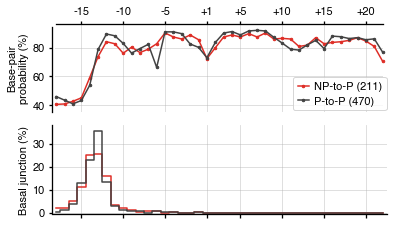

In [50]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,3.5))

for ys1,ys2,c,z,label,ml in zip(ysl1,ysl2,cs,zs,labels,mls):
    ax1.errorbar(xpos, ys1, color=c, zorder=z, marker='o', ms=2.5,
                 label='%s (%s)'%(label,len(ml)))
    ax2.step(xpos, ys2, color=c, zorder=z, where='mid') 
    
for ax in [ax1,ax2]:
    ax.set_xlim(xmin-.5, xmax+.5)
    ax.set_xticks(range(-15,1,5)+range(4,20,5))
    ax.tick_params(width=1.3, which='both')
    ax.grid(ls='-', which='both')
    
ax1.set_xticklabels([-15,-10,-5,'+1','+5','+10','+15','+20']); ax2.set_xticklabels([])
ax1.set_ylabel('Base-pair\nprobability (%)', fontsize=11)
ax1.xaxis.tick_top(); ax1.xaxis.set_label_position('top')
ax1.set_ylim(35,97)
ax1.spines['top'].set_visible(True); ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_bounds(35,95); ax1.spines['top'].set_bounds(xmin,xmax)
ax1.legend(loc=(.72,.02), handlelength=1, handletextpad=.5, labelspacing=.4, prop={'size':11})
sq1 = plt.Rectangle((xmin-.1,35), xmax-xmin+.1, 65.5, fc='w')
ax1.add_patch(sq1); ax1.grid(clip_path=sq1, which='both', ls='-', alpha=.5)

ax2.set_ylabel('Basal junction (%)')
ax2.set_ylim(-.5, 38); ax2.spines['left'].set_bounds(0,38)
ax2.set_zorder(-1)
    
fig.subplots_adjust(hspace=.15)
#fig.delaxes(ax2)
#fig.savefig(resultpath + '200929_f5f__nptop_ptop_structure_v2.pdf')#,dpi=300)